In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import xarray as xr
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [29]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

In [30]:
ftcw.keys()

dict_keys(['rel', 'relmm', 'abs', 'futslope', 'histslope', 'futinter', 'histinter'])

In [31]:
def relate_climate(hist_tcw, fut_tcw):
    ddic = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))
    hist_pcp = ddic['histslope']*hist_tcw+ddic['histinter']
    fut_pcp = ddic['futslope']*fut_tcw+ddic['futinter']
    prel = (fut_pcp-hist_pcp)/hist_pcp * 100
    trel = (fut_tcw-hist_tcw)/hist_tcw * 100
    dic = {'hist_pcp' : hist_pcp, 'fut_pcp' : fut_pcp, 'rel_pchange' : prel, 'rel_tchange' : trel}
    ipdb.set_trace()
    return dic

In [32]:
shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac =  np.mean(ftcw['relmm']) #3.11 # relative change
tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['relmm']) #0.18 #%
mmPerPercent = tcabsfac/tcwvfac

errperperc = tcabserr / tcrelerr

In [33]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)
    #ipdb.set_trace()
    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear'])*-1)
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))


In [34]:
cp4_read

{'period': ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut'],
 'shear': [array([13.122973]),
  array([16.145008]),
  array([12.626462]),
  array([14.523413])],
 'tcwv': [array([37.21887]),
  array([57.760437]),
  array([37.291157]),
  array([58.429615])]}

In [35]:
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')

In [36]:
cp4_df.loc['CP4fut','shear']

array([16.145008])

In [37]:
cp4_shear_diff = cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear']
cp25_shear_diff = cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear']

cp4_tcwv_diff = cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv']
cp25_tcwv_diff = cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv']

In [38]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP.csv', index_col='model_name')
#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [39]:
cmip_read['2040']

,Unnamed: 0,shear_mean,tcw_mean,tcw_hist,shear_hist
model_name,,,,,
inmcm4,0,0.889028,3.129124,35.395468,1.431171e+01
BNU-ESM,1,0.339458,9.538605,36.007971,1.270190e+01
IPSL-CM5A-MR,2,0.992621,8.764158,32.758006,1.192545e+01
CSIRO-Mk3-6-0,3,0.660493,5.414619,44.859928,5.538450e+35
MRI-ESM1,4,1.093094,5.927477,34.820140,9.024306e+00
MPI-ESM-MR,5,0.868122,7.094896,39.318021,1.266744e+01
MIROC-ESM-CHEM,6,1.927306,12.190766,33.566376,1.063018e+01
CMCC-CM,7,1.262251,8.049864,39.907365,1.168611e+01
MPI-ESM-LR,8,1.083029,7.273821,39.606890,1.312297e+01


In [40]:
(cmip_read['2040']).index[0]

'inmcm4'

> <ipython-input-31-b29237316ff1>(9)relate_climate()
      7     dic = {'hist_pcp' : hist_pcp, 'fut_pcp' : fut_pcp, 'rel_pchange' : prel, 'rel_tchange' : trel}
      8     ipdb.set_trace()
----> 9     return dic

ipdb> fut_tcw
model_name
inmcm4            41.652884
BNU-ESM           55.892780
IPSL-CM5A-MR      51.329897
CSIRO-Mk3-6-0     58.501330
MRI-ESM1          43.443341
MPI-ESM-MR        55.097193
MIROC-ESM-CHEM    57.962765
CMCC-CM           57.040343
MPI-ESM-LR        53.542274
HadGEM2-CC        44.883101
CanESM2           57.982299
bcc-csm1-1-m      44.988172
GISS-E2-R         53.065296
FGOALS-g2         48.357098
ACCESS1-3         44.527433
NorESM1-M         44.068130
GISS-E2-H-CC      51.993876
IPSL-CM5A-LR      47.090299
MIROC5            58.576276
CESM1-CAM5        56.196520
GFDL-ESM2M        52.141307
GISS-E2-H         53.191733
MRI-CGCM3         42.931190
MIROC-ESM         56.914416
CNRM-CM5          50.217414
CCSM4             50.381355
bcc-csm1-1        45.337465
GFDL-C

ipdb> quit


BdbQuit: 

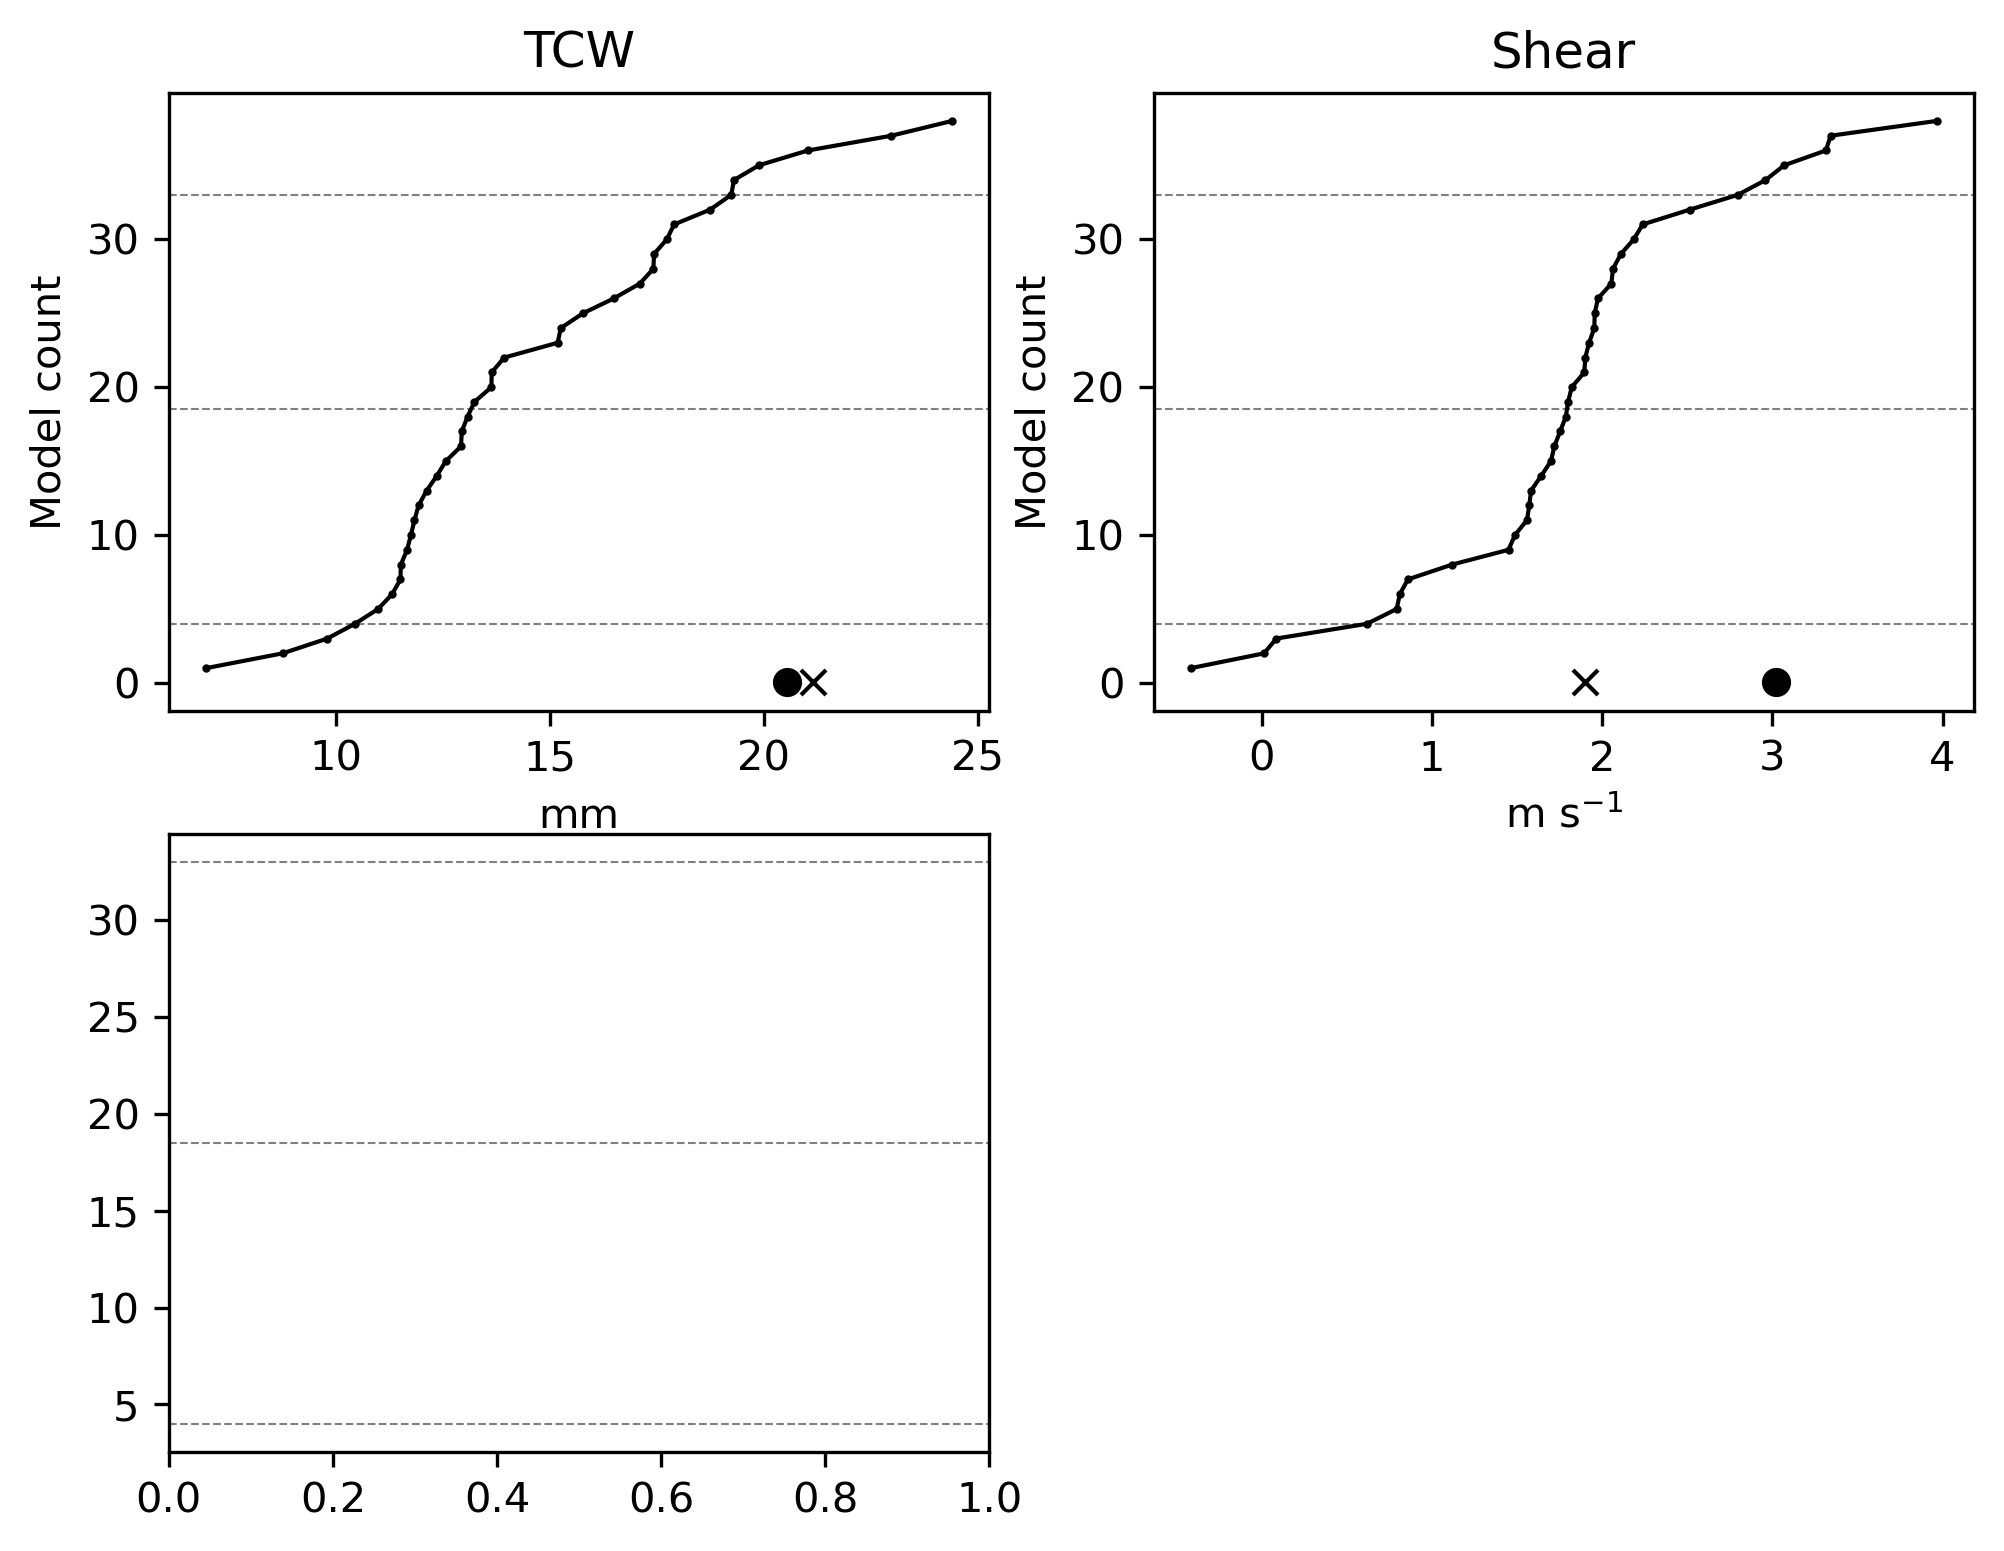

In [43]:
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

perc_dic = {}


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2080', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)

    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCW')
    ax1.set_xlabel('mm')  #kg m$^{-2}$
    ax1.set_ylabel('Model count')


    #ax1.axvline(0, linestyle='dashed', lw=1)

    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)
    
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model count')
    
    if ids == 2:

        ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x', label='P25', linestyle='')
        ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o', label='CP4', linestyle='')

        ax2.plot(cp25_shear_diff,0.03, color='k', marker='x', label='P25', linestyle='')
        ax2.plot(cp4_shear_diff,0.03, color='k', marker='o', label='CP4', linestyle='')
    else:
        
        
        ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x', linestyle='')
        ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o', linestyle='')

        ax2.plot(cp25_shear_diff,0.03, color='k', marker='x',  linestyle='')
        ax2.plot(cp4_shear_diff,0.03, color='k', marker='o',  linestyle='')
        
    ax1.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    

    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    climdic = relate_climate((cmip_read[stry])['tcw_hist'], (cmip_read[stry])['tcw_hist']+(cmip_read[stry])['tcw_mean'])
    
    prel = climdic['rel_pchange']
    
    ipdb.set_trace()
    
    x = prel
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    error_low = (((cmip_read[stry])['tcw_mean']) * (tcabsfac-tcabserr)  / mmPerPercent)[order]
    error_high = (((cmip_read[stry])['tcw_mean']) * (tcabsfac+tcabserr)  / mmPerPercent)[order]
    
    error_lowr = (((cmip_read[stry])['tcw_mean']) * (tcwvfac-tcrelerr))[order]
    error_highr = (((cmip_read[stry])['tcw_mean']) * (tcwvfac+tcrelerr))[order]
    
    #ipdb.set_trace()
    
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, label='TCW', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(cumulative))+1, error_low, error_high, color='lightgrey', zorder=99)
#     ax.axvline(0, linestyle='dashed', lw=1, color='grey')
#     ax.axhline(18.5, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print(stry, '10,90 perc shear model', mnames[perc[0]], mnames[perc[-1]])
    (perc_dic[stry])['shear'] = ( mnames[perc[0]], mnames[perc[-1]])
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, label='Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    error_low = ((((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * (tcabsfac-tcabserr)) / mmPerPercent)[order]
    error_high = ((((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * (tcabsfac+tcabserr)) / mmPerPercent)[order]
    
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc shear+tcw model', mnames[perc[0]], mnames[perc[-1]], perc)
    (perc_dic[stry])['shear+tcw'] = ( mnames[perc[0]], mnames[perc[-1]])
    
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, label='TCW+Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(cumulative))+1, error_low, error_high, color='seagreen', alpha=0.3, zorder=99)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ##############
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')
   
    plt.xlabel('Scaled P$_{max}95$ relative change (%)')
    plt.ylabel('Model count')
    ax.set_xlim(-5,84)

    plt.title(stry)
    if ids == 0:
        plt.legend(loc='lower right', fontsize=9)  #facecolor='lightgrey'
ax1.legend(fontsize=9)
#ax2.legend()

#ipdb.set_trace()
plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_rel_hourlyScaling.jpg')

In [19]:
perc_dic

{'2030': {'tcw': ('bcc-csm1-1-m', 'HadGEM2-ES'),
  'shear': ('CMCC-CESM', 'MIROC-ESM'),
  'shear+tcw': ('bcc-csm1-1-m', 'ACCESS1-0')},
 '2060': {'tcw': ('GFDL-ESM2M', 'IPSL-CM5A-MR'),
  'shear': ('CSIRO-Mk3-6-0', 'ACCESS1-0'),
  'shear+tcw': ('GFDL-ESM2M', 'HadGEM2-ES')},
 '2080': {'tcw': ('GISS-E2-R', 'CMCC-CMS'),
  'shear': ('FGOALS-g2', 'ACCESS1-0'),
  'shear+tcw': ('GISS-E2-R', 'BNU-ESM')}}

In [57]:
pkl.dump(perc_dic, open('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CMIPpercentiles_1090_Sahel_tcwShear.p', "wb"))

In [58]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

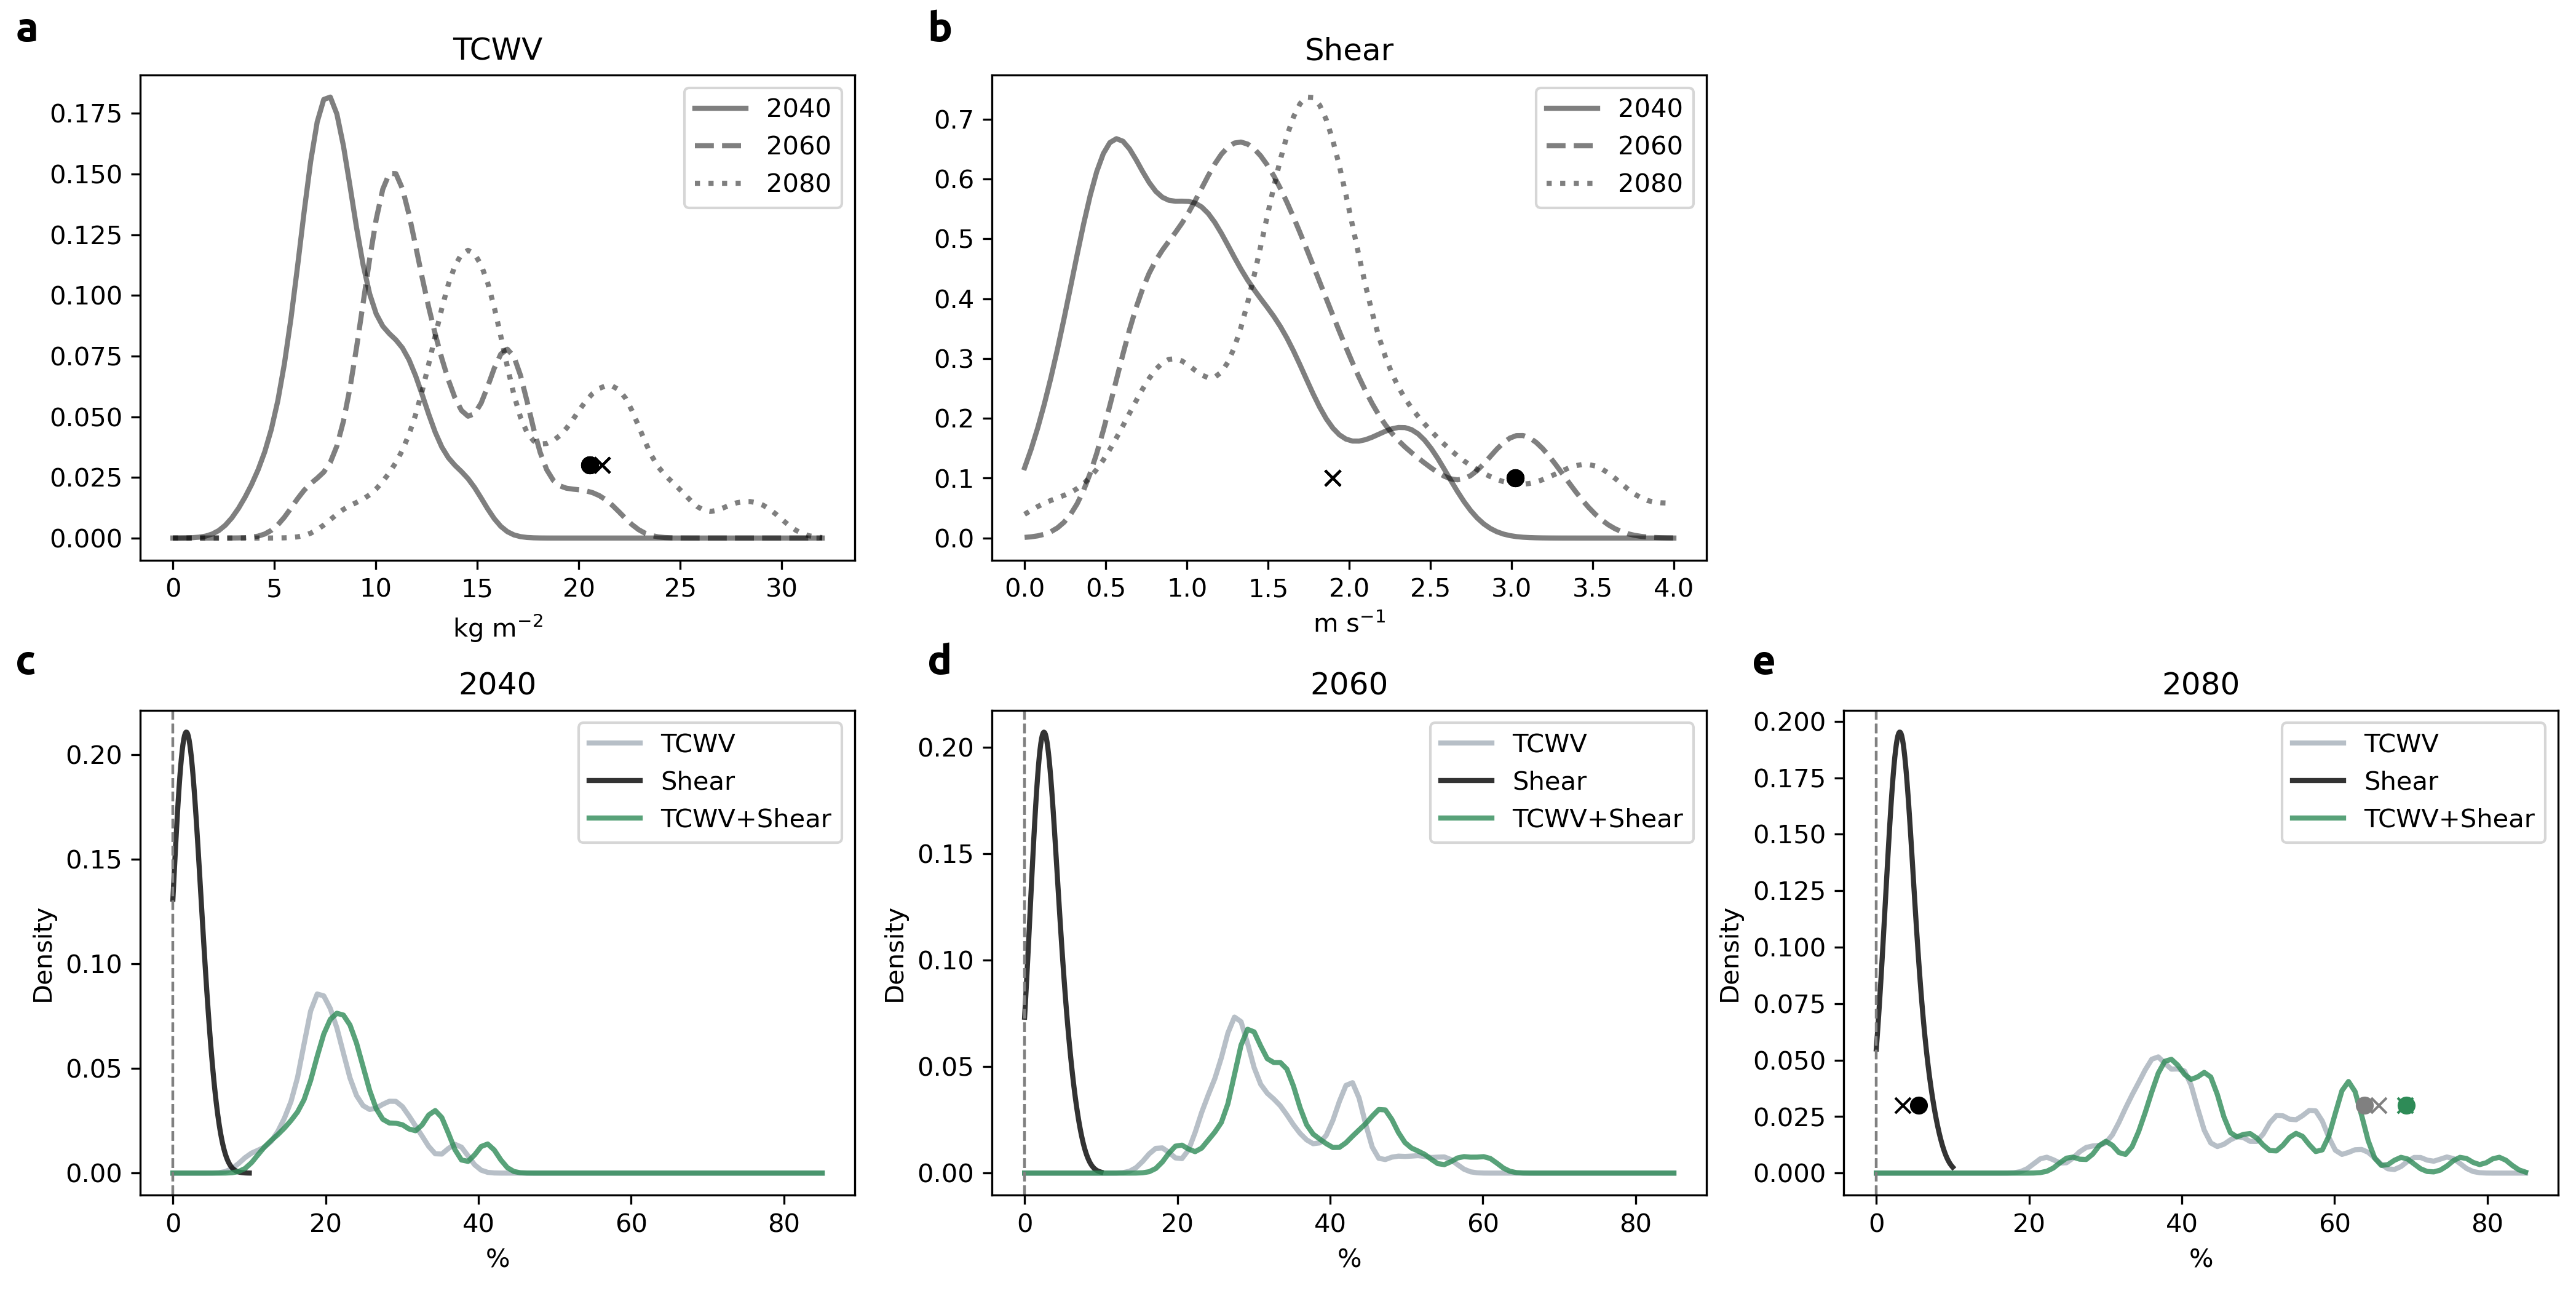

In [59]:

f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac
    x_grid = np.linspace(0, 32, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1)
    ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    #ax1.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
#         x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
#         x_grid = np.linspace(0, 25, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=1)
#         ax1.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax1.set_title('TCWV')
#         ax1.set_xlabel('kg m$^{-2}$')
#         #ax1.axvline(0, linestyle='dashed', lw=1)
        
    
    
    #
    x = (cmip_read[stry])['shear_mean']
    x_grid = np.linspace(0, 4, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=0.2)
    ax2.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    #plt.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
        
#         x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
#         x_grid = np.linspace(-3, 1, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=0.2)
#         ax2.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax2.set_title('Shear')
#         ax2.set_xlabel('m s$^{-1}$')
#         #plt.axvline(0, linestyle='dashed', lw=1)
        
    ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x')
    ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o')
    #ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp25_shear_diff,0.1, color='k', marker='x')
    ax2.plot(cp4_shear_diff,0.1, color='k', marker='o')
    #ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')
        

    ax = f.add_subplot(2,3,ids+4)
    ##########
    #tcplot = hist2d.basic_1d_binning(cmip_tc_perc['2080'].values, np.arange(np.min(cmip_tc_perc['2080']), np.max(cmip_tc_perc['2080']),1))
    #ax.bar(tcplot['xbins'], tcplot['nb']/np.sum(tcplot['nb']), color='grey', label='TCWV')

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac  / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='slategrey', alpha=0.5, lw=2, label='TCWV')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    x_grid = np.linspace(0, 10, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='k', alpha=0.8, lw=2, label='Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
#     if ids == 2:
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.01, color='grey', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.01, color='grey', marker='o')
#         ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.01, color='k', marker='x')
#         ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='k', marker='o')
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.01, color='seagreen', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='seagreen', marker='o')
        
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')

    plt.xlabel('%')
    plt.ylabel('Density')

    plt.title(stry)

    plt.legend()
ax1.legend()
ax2.legend()
plt.tight_layout()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_PDF_Sahelonly.png')

NameError: name 'cmip_tc_diff' is not defined

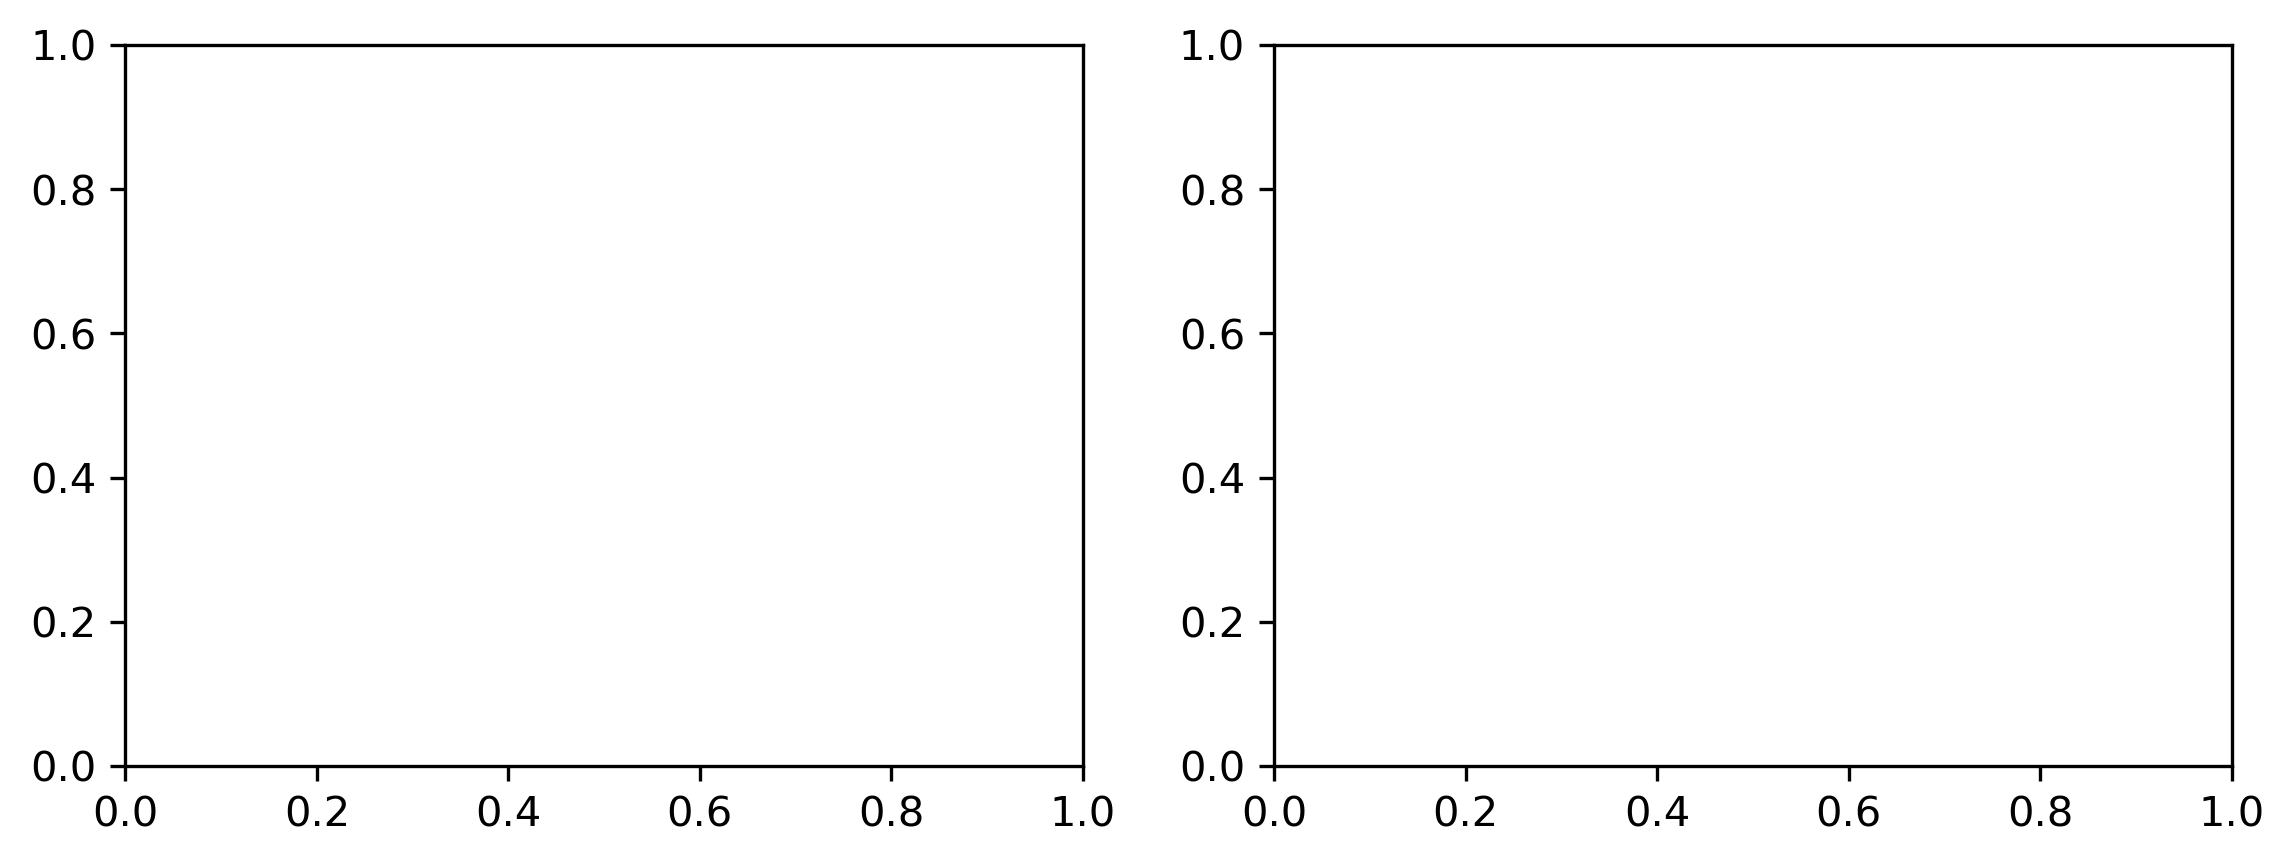

In [60]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

mk=3
linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_marker+uncertainty.png')